In [1]:
### Written by Cole Lord-May (clordmay@eoas.ubc.ca)

### This notebook is intended to be a follow-along with the example data provided.
### A handful of plots from the manuscript are not included as they don't help explain the methods.
### Additional plots are included when needed to make the methods more clear applicable to other users

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import gaussian_kde
import matplotlib
from matplotlib.patches import Ellipse
from numpy.lib.stride_tricks import sliding_window_view

In [2]:
cmap = matplotlib.colormaps['tab20']

def double_rot(u,v,w):
    theta = np.arctan2(np.mean(v),np.mean(u))
    u_tmp = u*np.cos(theta) + v*np.sin(theta)
    v_tmp = -u*np.sin(theta) + v*np.cos(theta)
    w_tmp = w
    
    phi = np.arctan2(np.mean(w_tmp),np.mean(u_tmp))
    u_rot = u_tmp*np.cos(phi) + w_tmp*np.sin(phi)
    v_rot = v_tmp
    w_rot = -u_tmp*np.sin(phi) + w_tmp*np.cos(phi)
    
    return u_rot,v_rot,w_rot

def ellip(x_,y_):
    cov = np.cov(x_, y_)

    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)

    angle = 1.
    if (lambda_[0]<lambda_[1]):
        lambda_[0],lambda_[1] = lambda_[1],lambda_[0]
        angle = ((np.rad2deg(np.arctan2(*v[:,0][::-1]))+180)-90)%360-180

    else:
        angle = np.rad2deg(np.arctan2(*v[:,0][::-1]))
    return angle, lambda_

def CG(gram,J,a,b):
        return np.sum(np.diagonal(gram[a:b, a:b])) - np.sum(gram[a:b, a:b]) / (b*J - a*J)

### This code was built using the architecture of https://github.com/deepcharles/ruptures
### Their code is more generalized and permits a wider range of mapping functions.
### However, this code is well suited to our problem and the usage of python is more optimized.
### In our testing, it runs approximately 10x faster.
### Note: This code is still slow on large timeseries. Increase J when testing to speed things up.
### Highly advised to run on 30 min chunks of data (or smaller).
    
def CPD_find(g,J=10,pen = 300):
    ### Jxjump dictates the output resolution.
    ### For final runs, set jump=1, as this increases the method's precision.
    ### However, jump=1 is VERY slow and requires a good processor.
    ### When testing, set jump=10 for fast runs.
    jump = 10
    
    ### Normalize penalty to jump.
    pen/=jump
    
    data = g.T[::jump]
    data = data-np.mean(data,axis=0)
    N = data.shape[0]

    ### if data is 1D, reshape to a column vector
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)


    ### After extensive testing, I'm fairly certain this it the fastest way to calculate the distance matrix
    ### Separating the last calculation into 2 lines decreases runtime by ~10%
    ### Something about space allocation, I suspect.
    D = pdist(data, metric="sqeuclidean")
    temp = squareform(-D/np.median(D,overwrite_input=True))
    gram = np.exp(temp)

    ### Course-grain over JxJ blocks. This accounts for a significant speed increase
    G = np.sum(gram.reshape((N//J,J,N//J,J)),axis=(1,3))

    ### Partition dictionary
    parts = {0:{(0, 0): 0}}

    adm = []
    ### Loop over all possible breakpoints
    for bkp in range(J, N+J, J):
        adm.append(bkp-J)
        subprob = []
        for t in adm:
            tmp_part = parts[t].copy()
            AA = CG(G,J,t//J, bkp//J) + pen
            tmp_part.update({(t, bkp): AA})
            subprob.append(tmp_part)


        parts[bkp] = min(subprob, key=lambda d: sum(d.values()))
        adm = [t for t, part in zip(adm, subprob) if sum(part.values()) <= sum(parts[bkp].values()) + pen]


    best_part = parts[N]
    del best_part[(0, 0)]


    R = sorted(set(np.array(list(best_part)).flatten()*jump))
    R[-1]+=-1
    return R


In [3]:
### Read in the data array
### This is 30 mins and has already had double rotation applied
G = np.array(pd.read_csv("sample_data.csv")).T
U,V,W,T = G

In [4]:
### Locate the changepoints
R = CPD_find(G)

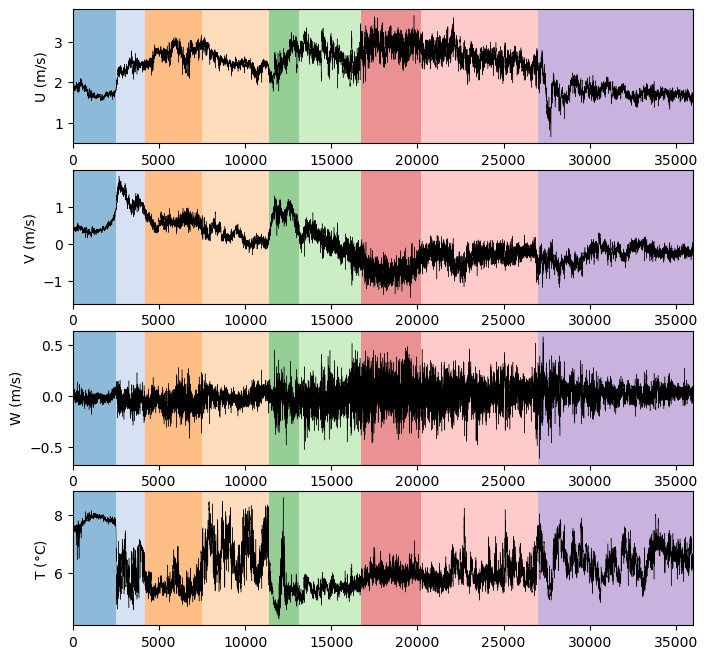

In [5]:
### Plot u,v,w,T with changepoints marked by changing background colour.

fig,axs = plt.subplots(4,1,figsize=(8,8))

ylabs = ["U (m/s)","V (m/s)","W (m/s)","T ($\degree$C)"]

for ind,ax in enumerate(axs):
    for i in range(len(R)-1):
        ax.axvspan(R[i], R[i+1], facecolor=cmap(i%20), alpha=0.5)
        
    ax.plot(G[ind],c="k",lw="0.3")
    
    ax.set_ylabel(ylabs[ind])
    ax.set_xlim(0,36000)

Text(0.5, 0, 'T ($\\degree$C)')

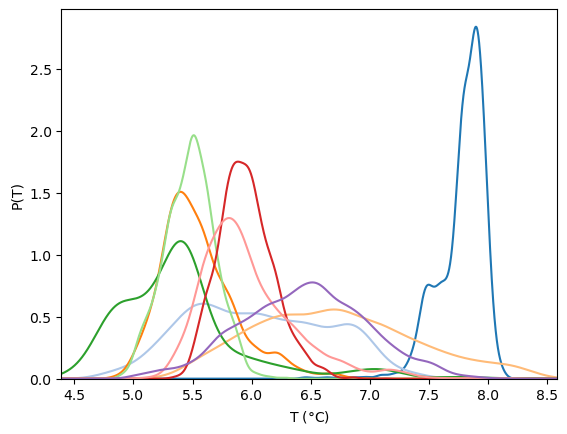

In [6]:
### We can also look at the distributions of a variable.
### In this case, we look at T distributions in each segment, coloured the same as above

for i in range(len(R)-1):
    kde = gaussian_kde(T[R[i]:R[i+1]])
    xspace = np.linspace(np.min(T),np.max(T),10000)
    plt.plot(xspace,kde(xspace),c=cmap(i%20))
    
    
plt.xlim(xspace[0],xspace[-1])
plt.ylim(ymin=0)
plt.ylabel("P(T)")
plt.xlabel("T ($\degree$C)")

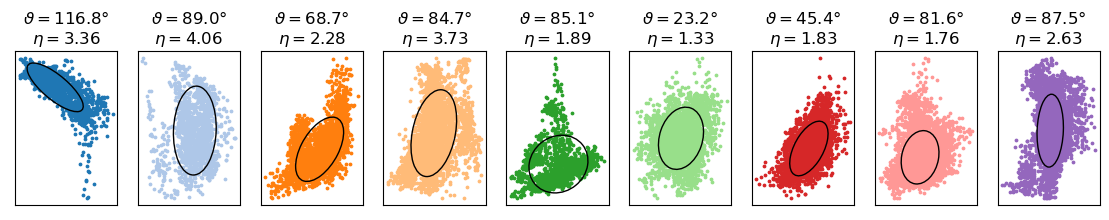

In [7]:
### Next, we apply ellipse filtering to scatter of u-T
### We remove the axes in the interest of visual clarity
 
fig,axs = plt.subplots(1,len(R)-1,figsize=(14,2))
for i,ax in enumerate(axs):
    ax.scatter(U[R[i]:R[i+1]]-U[R[i]:R[i+1]].mean(),T[R[i]:R[i+1]]-T[R[i]:R[i+1]].mean(),s=3,color=cmap(i%20))
    
    a, (b,c) = ellip(U[R[i]:R[i+1]],T[R[i]:R[i+1]])
    ell = Ellipse(xy=(0,0),width=b*3, height=c*3,angle=a) ### x3 width and height scale for visuals
    ell.set_facecolor('none')
    ell.set_edgecolor('k')
    ax.add_artist(ell)
    ax.set_title(rf"$\vartheta = {round(a,1)}\degree$"+"\n"+rf"$\eta={round(b/c,2)}$")
    
    ax.set_xticks([])
    ax.set_yticks([])

In [8]:
### The first interval (blue) clearly shows the WSM below the measurement height of 2m.

### The next (light blue) shows high variance in T (y axis) and low variance in u (x axis)
### marked by a very high eta -> Indicative that WSM is at, or very near 2m.

### The next few intervals show a regime where the the WSM is above 2m, but not by very much
### indicated by the high angle.

### The light green and red intervals pass the ellipse filtering criteria set out in the paper.

### Let's explore the affect of each interval on covariance (flux) calculations
### We introduce non-orthogonal multiresolution flux decomposition
### to view contibutions to covariance as a function of timescale

### This code was not heavily used in this manuscript, but features more heavily in our upcoming manuscript.
### As such, it isn't really commented.
def Delta_new(var,m):
    return np.sum(sliding_window_view(var[m:],window_shape = m)-sliding_window_view(var[:-m],window_shape = m),axis=1)/(2*m)

def covstar_new(var1,var2,N,m):
    return 1/(N-2*m+1) * np.sum(Delta_new(var1,m)*Delta_new(var2,m))

def non_orth(V1,V2,Mmax=20):
    test1 = []
    ascale = []
    N = len(V1)
    mrange = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,22,26,30,34,
             38,42,46,52,58,66,74,82,94,105,115,125,135,
              150,180,210,240,270,300,340,380,420,460,
              500,550,600,700,800,900,1000,1100,1300,1500,
              1800,2100,2400,3000,4000,5000]) ### customizable
    
    mrange = mrange[mrange<(N/2)] 
    ascale = 2*mrange/20
    test1 = np.array([covstar_new(V1,V2,N,m) for m in mrange])
        
    return ascale,test1

Text(0, 0.5, "contribtuion to $u'w'$")

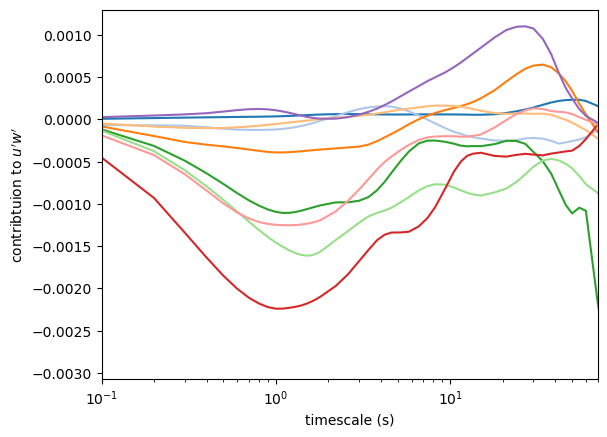

In [9]:
### The utility of this method is most apparent when looking at momentum flux ~ u'w'

### We see that the light green and red intervals, 
### which we identified as being "representative of surface conditions" have the largest u'w'
### The others all have very low u'w', as the sensor is too far from the surface to correctly 
### represent surface conditions

### So, to measure the approximate momentum flux, we want to only measure the covariance between u' and w'
### when we are far from the WSM.
### For very long intervals (5 min+), it's usually best to split them up (e.g. into 1 min segments).

for i,ax in enumerate(axs):
    plt.plot(*non_orth(U[R[i]:R[i+1]],W[R[i]:R[i+1]]),color=cmap(i%20))

plt.xlim(0.1,70)
plt.semilogx()
plt.xlabel("timescale (s)")
plt.ylabel("contribtuion to $u'w'$")

In [10]:
### Then, we assess the average u'w' is from the "good" subintervals that pass our filtering.
### This is a rather crude approach, but communicates the idea.
### Importantly, we need to also consider the length of data used to calculate the subinterval.


uwcovs = np.array([np.cov(U[R[i]:R[i+1]],W[R[i]:R[i+1]])[0][1] for i in range(len(R)-1)])
### ^^ We find that some of these are positive, indicating a measurement above WSM.
good_inds = np.array([5,6])
sub_lengths = np.array([R[i+1]-R[i] for i in range(len(R)-1)])
print(f"average u'w' {np.average(uwcovs[good_inds],weights = sub_lengths[good_inds])}")
print(f"calculated with {round(sum(sub_lengths[good_inds])/36000*30,2)} min of data")


average u'w' -0.012105983202509791
calculated with 5.92 min of data
